이번 강의에서는 교재 Example Example 6.5: Windy Gridworld를 구현합니다. 우선 문제를 잘 읽어 보세요. 
  - 성신여자대학교 AI융합학부 강화학습 수업을 위해 작성한 자료입니다. 2025년 8월 26일 초안을 작성하였고, 2025년 10월 3일 업데이트하였습니다. 
  - 코드는 2018년 작성한 코드를 바탕으로 Claude Pro를 이용해 변수명 등을 수정하였습니다. 

# 1. Exercise 6.5: Windy Gridworld 
설명을 잘 읽고, 문제를 정의합니다. 'Stochastic wind'는 다른 방식으로 정의해도 상관 없어요. 

Exercise 6.10: Stochastic Wind (programming) Re-solve the windy gridworld task with King’s moves, assuming that the e↵ect of the wind, if there is any, is stochastic, sometimes varying by 1 from the mean values given for each column. That is, a third of the time you move exactly according to these values, as in the previous exercise, but also a third of the time you move one cell above that, and another third of the time you move one cell below that. For example, if you are one cell to the right of the goal and you move left, then one-third of the time you move one cell above the goal, one-third of the time you move two cells above the goal, and one-third of the time you move to the goal.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


GRID_HEIGHT = 7
GRID_WIDTH = 10

# 바람의 세기(각 열에 대한 y축 이동)입니다.
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0] # (x=3,4,5는 1칸, x=6,7은 2칸, x=8은 1칸 위로 밀림)

# 시작 및 목표 상태입니다.
START_STATE = (3, 0) # (y, x)
GOAL_STATE = (3, 7)  # (y, x)

# 행동을 정의(dy, dx)해 줍니다. 예제의 4방향, 8방향, 8방향+정지 행동을 모두 구현해 봅니다.
# (y가 증가하면 아래로, y가 감소하면 위로)
# Up, Down, Left, Right
ACTIONS_4 = [(-1, 0), (1, 0), (0, -1), (0, 1)] 
# King's Moves: Up, Down, Left, Right, Up-Left, Up-Right, Down-Left, Down-Right
ACTIONS_8 = ACTIONS_4 + [(-1, -1), (-1, 1), (1, -1), (1, 1)]
# 8방향 + Stay
ACTIONS_9 = ACTIONS_8 + [(0, 0)]

# Sarsa 파라미터로 알고리즘을 비교하기 위해 다른 알고리즘에서도 동일하게 사용합니다.
ALPHA = 0.5
EPSILON = 0.1
GAMMA = 1.0 # Given discount factor입니다.

REWARD_PER_STEP = -1
REWARD_GOAL = 0

def env_step_stochastic_wind(state, action_idx, current_actions):
    """
    Stocasitc wind 문제에서의 바람을 구현합니다. 
    바람은 평균값에서 -1, 0, +1로 변동할 수 있습니다 (각각 1/3 확률).
    """
    y, x = state
    dy, dx = current_actions[action_idx]

    # 행동에 따른 다음 위치(바람 적용 전)이고,
    next_y_after_action = y + dy
    next_x_after_action = x + dx

    # 바람 적용 후 입니다.
    final_next_y = next_y_after_action
    final_next_x = next_x_after_action

    if 0 <= final_next_x < GRID_WIDTH: # 그리드 내의 x좌표일 때만 바람 적용합니다. 바람이 부는 위치가 있지요?
        mean_wind_effect = WIND[final_next_x]
        
        # 확률적으로 바람의 효과 결정(-1, 0, +1 변동)합니다.
        rand_val = np.random.rand()
        if rand_val < 1/3:                                      # 1/3 확률로 바람 효과가 평균보다 1 감소합니다.
            stochastic_wind_effect = mean_wind_effect - 1
        elif rand_val < 2/3:                                    # 1/3 확률로 바람 효과가 평균과 동일합니다.
            stochastic_wind_effect = mean_wind_effect
        else:                                                   # 1/3 확률로 바람 효과가 평균보다 1 증가합니다.
            stochastic_wind_effect = mean_wind_effect + 1
        
        final_next_y -= stochastic_wind_effect                  # 그림 그리는 게 조금 헷깔릴 수 있는데, 교재의 그림처럼 바람이 위로 분다는 것은 y 인덱스 감소시킵니다. 부호를 맞추는 건 본인의 알고리즘에 맞게 하면 돼요.

    # 경계 처리도 해 줍니다.
    final_next_y = max(0, min(final_next_y, GRID_HEIGHT - 1))
    final_next_x = max(0, min(final_next_x, GRID_WIDTH - 1))

    next_state = (final_next_y, final_next_x)

    reward = REWARD_PER_STEP
    if next_state == GOAL_STATE:
        reward = REWARD_GOAL       

    return next_state, reward

def plot_results(results, labels, title, x_limit=8000):
    plt.figure(figsize=(12, 6))
    
    for i, res in enumerate(results):
        cumulative_steps = np.cumsum(res)
        # x_limit을 넘지 않는 에피소드만 그리는데, 아마 그려보면 알겠지만 너무 긴 에피소드를 교재와 같은 그래프랑 다르게 안 예쁘게 나와서 추가합니다. 
        episodes_within_limit = np.sum(cumulative_steps <= x_limit)
        
        plt.plot(cumulative_steps[:episodes_within_limit], np.arange(1, episodes_within_limit + 1), label=labels[i])
    
    plt.xlabel('Time Steps (Total Steps)')
    plt.ylabel('Episodes')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xlim(0, x_limit)
    plt.show()

def plot_trajectory(Q, actions_set, start_state, goal_state, title="Optimal Trajectory"): # 최적 Q 값에 따른 에이전트의 움직임 궤적을 시각화합니다.
    plt.figure(figsize=(GRID_WIDTH, GRID_HEIGHT + 1.0))
    
    plt.imshow(np.zeros((GRID_HEIGHT, GRID_WIDTH)), cmap='bone_r', origin='upper', 
               extent=[-0.5, GRID_WIDTH-0.5, GRID_HEIGHT-0.5, -0.5])    # extent: [left, right, bottom, top]
    
    # 바람 화살표를 시각화합니다.
    for x in range(GRID_WIDTH):
        if WIND[x] > 0:
            plt.arrow(x, GRID_HEIGHT - 0.5, 0, -0.4 * WIND[x], color='blue', head_width=0.2, head_length=0.2, alpha=0.6)
            plt.text(x, GRID_HEIGHT + 0.2, str(WIND[x]), color='blue', ha='center', va='top', fontsize=10)

    plt.text(start_state[1], start_state[0], 'S', color='green', ha='center', va='center', fontsize=12, weight='bold')
    plt.text(goal_state[1], goal_state[0], 'G', color='red', ha='center', va='center', fontsize=12, weight='bold')
    plt.hlines(y=np.arange(-0.5, GRID_HEIGHT), xmin=-0.5, xmax=GRID_WIDTH-0.5, color='black', linewidth=0.5)
    plt.vlines(x=np.arange(-0.5, GRID_WIDTH), ymin=-0.5, ymax=GRID_HEIGHT-0.5, color='black', linewidth=0.5)
    plt.xticks([]) 
    plt.yticks([]) 
    
    path_x = [start_state[1]]
    path_y = [start_state[0]]

    max_steps = 1000 
    current_iter_state = START_STATE
    
    # 그냥 구현을 하면 무한 루프에 빠지기 쉽습니다. 이전에 방문했던 상태를 추적할 수 있도록 구현해 주어야 합니다. 이런 부분은 직접 코딩을 해 봐야 느껴 지겠지요?
    visited_states = set() 

    for step_count in range(max_steps): 
        if current_iter_state == GOAL_STATE:
            break
        if current_iter_state in visited_states: # 무한 루프 감지(같은 상태를 여러 번 방문하는 경우)해서 빠져나옵니다.
            # print(f"Trajectory stuck in a loop at state {current_iter_state} after {step_count} steps.") # 이건 디버깅할 때 썼던 로그입니다. 필요하면 켜서 보세요.
            break
        visited_states.add(current_iter_state)

        y, x = current_iter_state
        # 최적 정책 (가장 높은 Q 값)에 따라 행동 선택합니다.
        best_action_idx = np.argmax(Q[y, x, :])
        dy, dx = actions_set[best_action_idx]
        
        # 다음 상태 계산(바람 포함)하고,
        next_y_unwind = y + dy
        next_x_unwind = x + dx

        next_y_winded = next_y_unwind
        if 0 <= next_x_unwind < GRID_WIDTH:
            # 그림 그릴 때는 plot_trajectory에서는 결정론적 바람만 적용합니다. 실제 현상에서는 stochastic wind를 적용하지만, 궤적을 그릴 때는, 그러니까 보고서에 그래프를 그린다고 생각하면 결정론적 바람이 더 직관적이기 때문입니다.
            next_y_winded -= WIND[next_x_unwind]

        final_next_y = max(0, min(next_y_winded, GRID_HEIGHT - 1))
        final_next_x = max(0, min(next_x_unwind, GRID_WIDTH - 1))
        
        # 궤적을 선으로 그리기주어야 하므로,
        plt.plot([current_iter_state[1], final_next_x], [current_iter_state[0], final_next_y], 'r-o', markersize=3, linewidth=1)
        
        current_iter_state = (final_next_y, final_next_x)
        path_x.append(current_iter_state[1])
        path_y.append(current_iter_state[0])
    
    # 그리고 최종 궤적을 굵은 선으로 다시 그려 강조합니다.
    plt.plot(path_x, path_y, 'r-', linewidth=2, marker='o', markersize=4)

    plt.title(title)
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.show()

## 1.1. (Review) Sarsa (on-policy TD control) for estimating $Q\approx q_\ast$

  0%|          | 0/8000 [00:00<?, ?it/s]

100%|██████████| 8000/8000 [00:01<00:00, 6793.06it/s]


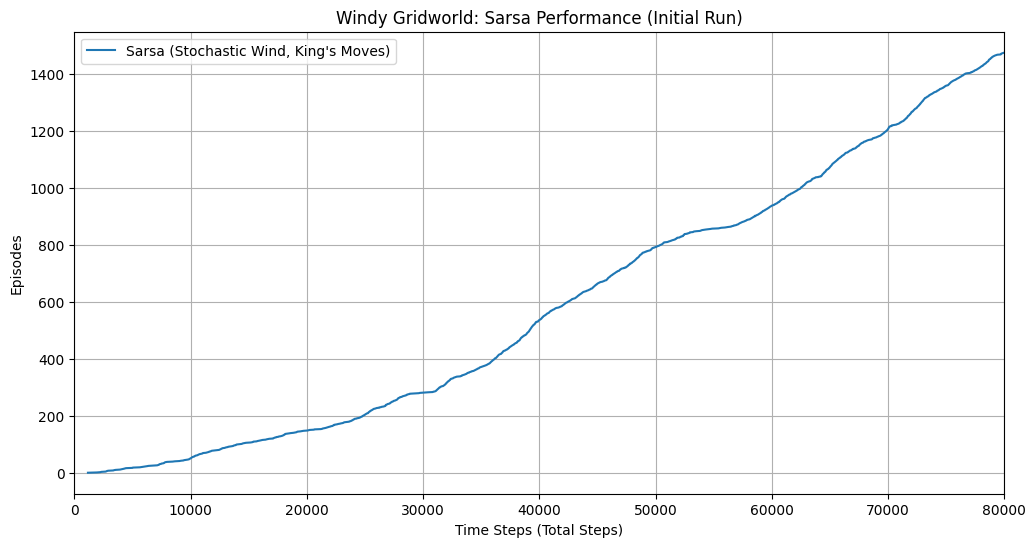


Optimal Trajectory with Sarsa (Stochastic Wind):


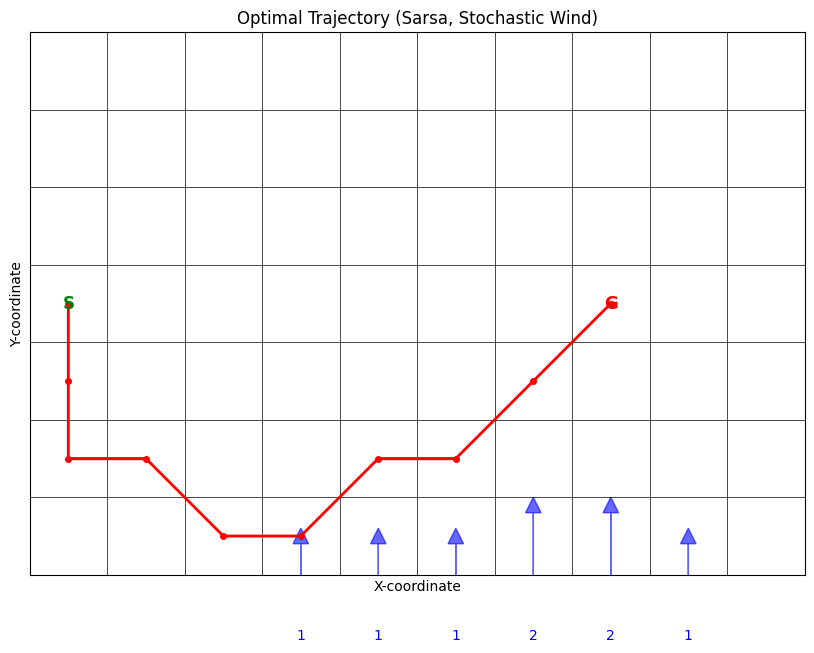

In [12]:
def sarsa_agent_stochastic_wind(num_episodes, actions_set):
    num_actions = len(actions_set)
    Q = np.zeros((GRID_HEIGHT, GRID_WIDTH, num_actions))
    episode_steps = []

    for episode in tqdm(range(num_episodes)):
        current_state = START_STATE
        steps = 0

        # epsilon-greedy 정책에 따라 초기 행동 선택합니다.
        if np.random.rand() < EPSILON:
            current_action_idx = np.random.randint(num_actions)
        else:
            current_action_idx = np.argmax(Q[current_state[0], current_state[1], :])

        while current_state != GOAL_STATE:
            steps += 1
            if steps > 5000: 
                break 
            
            next_state, reward = env_step_stochastic_wind(current_state, current_action_idx, actions_set)
            
            # 다음 상태에서 epsilon-greedy 정책에 따라 다음 행동 선택합니다. On-policy죠?
            if next_state == GOAL_STATE:
                next_action_idx = None 
            elif np.random.rand() < EPSILON:
                next_action_idx = np.random.randint(num_actions)
            else:
                next_action_idx = np.argmax(Q[next_state[0], next_state[1], :])

            # Sarsa 업데이트입니다. 교재랑 최대한 동일하게 변수명 등을 맞춰 주었으니 읽기 쉬울 거예요.
            old_q = Q[current_state[0], current_state[1], current_action_idx]
            target_q_prime = Q[next_state[0], next_state[1], next_action_idx] if next_state != GOAL_STATE else 0

            Q[current_state[0], current_state[1], current_action_idx] = old_q + ALPHA * (reward + GAMMA * target_q_prime - old_q)

            # 상태 및 행동 업데이트하고, 다음 스탭을 준비합니다.
            current_state = next_state
            current_action_idx = next_action_idx
            
            if next_action_idx is None and current_state == GOAL_STATE:
                break

        episode_steps.append(steps)
    
    return episode_steps, Q


NUM_EPISODES = 8000 # 혹시 결과가 잘 나오지 않는다면 optimal 궤적을 찾지 못한 것일 수 있으니, 에피소드를 늘려 보세요.
episode_steps_stochastic_8, Q_stochastic_8 = sarsa_agent_stochastic_wind(NUM_EPISODES, ACTIONS_8)

all_results_sarsa_initial = [episode_steps_stochastic_8]
all_labels_sarsa_initial = ['Sarsa (Stochastic Wind, King\'s Moves)']
plot_results(all_results_sarsa_initial, all_labels_sarsa_initial, 'Windy Gridworld: Sarsa Performance (Initial Run)', x_limit=NUM_EPISODES * 10)

print("\nOptimal Trajectory with Sarsa (Stochastic Wind):")
plot_trajectory(Q_stochastic_8, ACTIONS_8, START_STATE, GOAL_STATE, "Optimal Trajectory (Sarsa, Stochastic Wind)")

## 1.2. (Review) Q-learning, for estimating $Q \approx q_\ast$

Q-learning으로 문제를 풀어 봅시다. 6장에서 사용한 알고리즘을 다른 문제에 적용해 보면서 익숙해 지면 됩니다. 

100%|██████████| 8000/8000 [00:02<00:00, 3753.92it/s]


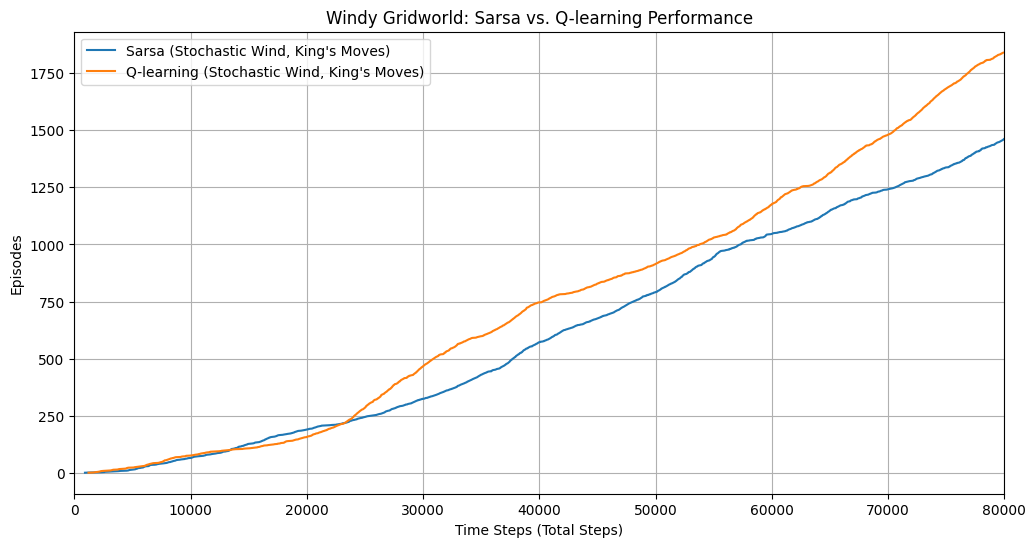


Optimal Trajectory with Q-learning (Stochastic Wind):


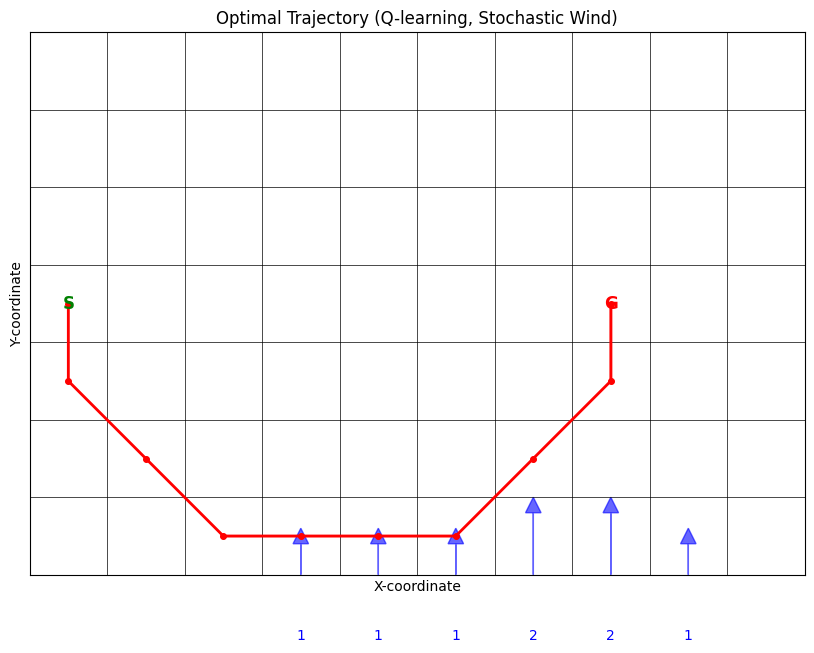

In [5]:
def q_learning_agent(num_episodes, actions_set):
    num_actions = len(actions_set)
    Q = np.zeros((GRID_HEIGHT, GRID_WIDTH, num_actions))
    episode_steps = []

    for episode in tqdm(range(num_episodes)):
        current_state = START_STATE
        steps = 0

        while current_state != GOAL_STATE:
            steps += 1
            if steps > 5000: 
                break 

            # Sarsa와 똑같이 epsilon-greedy 정책에 따라 현재 행동 선택합니다. 이게 결국 behavior policy가 됩니다.
            if np.random.rand() < EPSILON:
                current_action_idx = np.random.randint(num_actions)
            else:
                current_action_idx = np.argmax(Q[current_state[0], current_state[1], :])

            next_state, reward = env_step_stochastic_wind(current_state, current_action_idx, actions_set)

            # Q-learning 업데이트입니다. 업데이트는 target policy (greedy policy)를 따릅니다. target과 behavior가 다르지요? Off-policy입니다.
            old_q = Q[current_state[0], current_state[1], current_action_idx]
            
            # 다음 상태에서 가장 높은 Q 값 선택합니다. 구현을 위해 목표 상태에 도달하면 다음 Q 값은 0이 됨
            max_next_q = np.max(Q[next_state[0], next_state[1], :]) if next_state != GOAL_STATE else 0

            Q[current_state[0], current_state[1], current_action_idx] = old_q + ALPHA * (reward + GAMMA * max_next_q - old_q)

            current_state = next_state
            
            if current_state == GOAL_STATE:
                break

        episode_steps.append(steps)
    
    return episode_steps, Q

NUM_EPISODES = 8000
episode_steps_q_learning, Q_q_learning = q_learning_agent(NUM_EPISODES, ACTIONS_8)

all_results_q_comp = [episode_steps_stochastic_8, episode_steps_q_learning]
all_labels_q_comp = ['Sarsa (Stochastic Wind, King\'s Moves)', 'Q-learning (Stochastic Wind, King\'s Moves)']
plot_results(all_results_q_comp, all_labels_q_comp, 'Windy Gridworld: Sarsa vs. Q-learning Performance', x_limit=NUM_EPISODES * 10)

print("\nOptimal Trajectory with Q-learning (Stochastic Wind):")
plot_trajectory(Q_q_learning, ACTIONS_8, START_STATE, GOAL_STATE, "Optimal Trajectory (Q-learning, Stochastic Wind)")

# 2. $n$-step Boostrapping

## 2.1. 2-step Sarsa (on-policy TD control) for estimating $Q\approx q_\ast$

다음 코드는 ChatGPT 5.0으로 생성한 코드입니다. 생성형 AI 서비스를 구독하지 않는 학생들을 위해 제공하며, 이를 참고하여 여러분의 코드를 완성해 보세요. 

100%|██████████| 8000/8000 [00:02<00:00, 2732.59it/s]


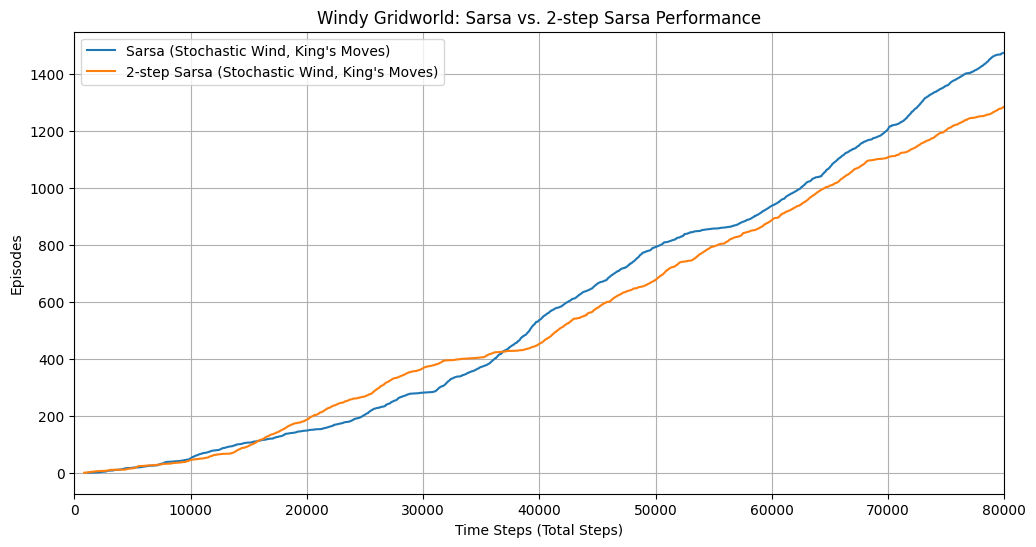


Optimal Trajectory with 2-step Sarsa (Stochastic Wind):


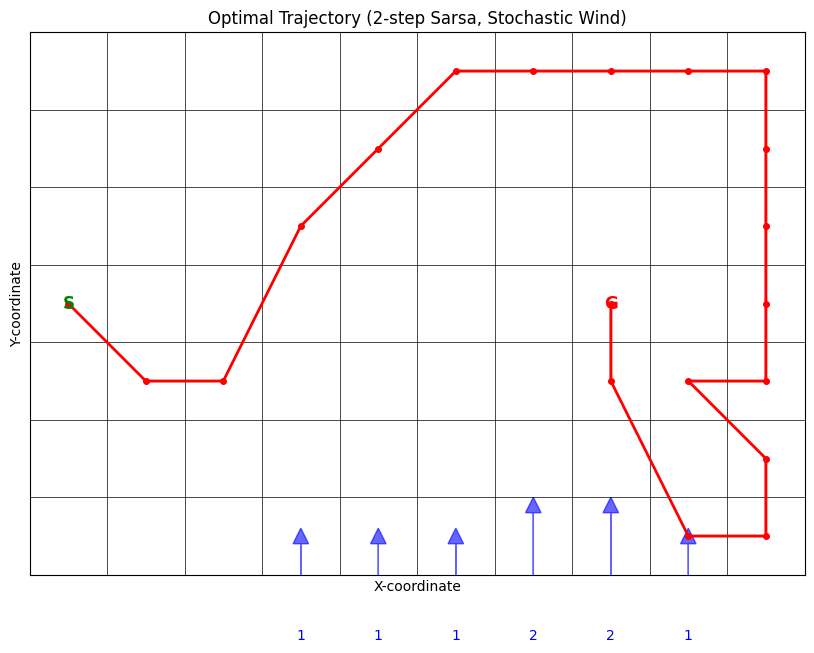

In [23]:
def two_step_sarsa_agent(num_episodes, actions_set):
    num_actions = len(actions_set)
    Q = np.zeros((GRID_HEIGHT, GRID_WIDTH, num_actions))
    episode_steps = []

    for episode in tqdm(range(num_episodes)):
        current_state = START_STATE
        steps = 0
        
        if np.random.rand() < EPSILON:
            S0_action_idx = np.random.randint(num_actions)
        else:
            S0_action_idx = np.argmax(Q[current_state[0], current_state[1], :])

        while current_state != GOAL_STATE:
            steps += 1
            if steps > 5000: 
                break 
            
            next_state_s1, reward_r1 = env_step_stochastic_wind(current_state, S0_action_idx, actions_set)

            if next_state_s1 == GOAL_STATE:
                S1_action_idx = None
            elif np.random.rand() < EPSILON:
                S1_action_idx = np.random.randint(num_actions)
            else:
                S1_action_idx = np.argmax(Q[next_state_s1[0], next_state_s1[1], :])
            
            if next_state_s1 == GOAL_STATE:
                target_q_prime = 0 
                
                Q[current_state[0], current_state[1], S0_action_idx] += ALPHA * (reward_r1 + GAMMA * target_q_prime - Q[current_state[0], current_state[1], S0_action_idx])
                
                current_state = next_state_s1 
                break
            
            next_state_s2, reward_r2 = env_step_stochastic_wind(next_state_s1, S1_action_idx, actions_set)
            
            if next_state_s2 == GOAL_STATE:
                S2_action_idx = None
            elif np.random.rand() < EPSILON:
                S2_action_idx = np.random.randint(num_actions)
            else:
                S2_action_idx = np.argmax(Q[next_state_s2[0], next_state_s2[1], :])

            Q_S2_A2 = Q[next_state_s2[0], next_state_s2[1], S2_action_idx] if next_state_s2 != GOAL_STATE else 0

            target = reward_r1 + GAMMA * reward_r2 + (GAMMA**2) * Q_S2_A2
            
            Q[current_state[0], current_state[1], S0_action_idx] += ALPHA * (target - Q[current_state[0], current_state[1], S0_action_idx])

            current_state = next_state_s1
            S0_action_idx = S1_action_idx
            
            if current_state == GOAL_STATE:
                break

        episode_steps.append(steps)
    
    return episode_steps, Q

NUM_EPISODES = 8000
episode_steps_2step_sarsa, Q_2step_sarsa = two_step_sarsa_agent(NUM_EPISODES, ACTIONS_8)

all_results_2s_comp = [episode_steps_stochastic_8, episode_steps_2step_sarsa]
all_labels_2s_comp = ['Sarsa (Stochastic Wind, King\'s Moves)', '2-step Sarsa (Stochastic Wind, King\'s Moves)']
plot_results(all_results_2s_comp, all_labels_2s_comp, 'Windy Gridworld: Sarsa vs. 2-step Sarsa Performance', x_limit=NUM_EPISODES * 10)

print("\nOptimal Trajectory with 2-step Sarsa (Stochastic Wind):")
plot_trajectory(Q_2step_sarsa, ACTIONS_8, START_STATE, GOAL_STATE, "Optimal Trajectory (2-step Sarsa, Stochastic Wind)")

## 2.2. Off-policy 2-step Sarsa for estimating $Q\approx q_\ast$

100%|██████████| 8000/8000 [00:04<00:00, 1799.12it/s]


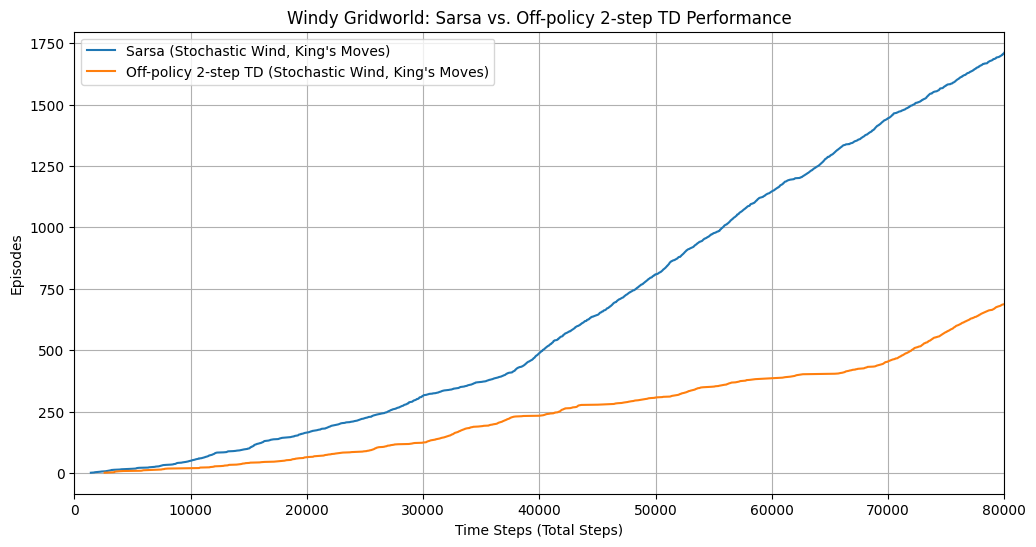


Optimal Trajectory with Off-policy 2-step TD (Stochastic Wind):


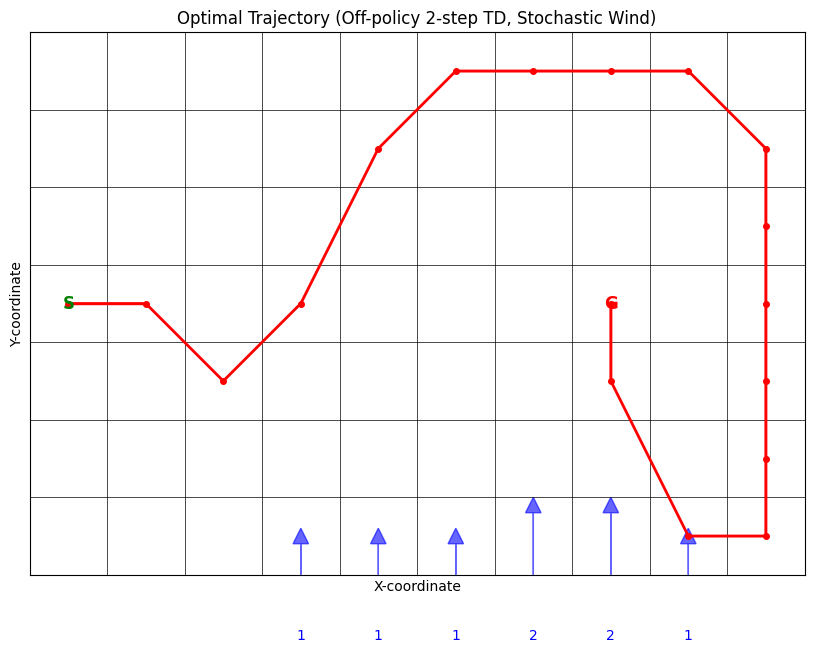

In [24]:
N_STEP = 2 

def get_behavior_action(Q_table, state, num_actions):
    if np.random.rand() < EPSILON:
        return np.random.randint(num_actions)
    else:
        return np.argmax(Q_table[state[0], state[1], :])

def get_target_action(Q_table, state):
    return np.argmax(Q_table[state[0], state[1], :])

def off_policy_two_step_td_agent(num_episodes, actions_set):
    num_actions = len(actions_set)
    Q = np.zeros((GRID_HEIGHT, GRID_WIDTH, num_actions))
    episode_steps = []

    for episode in tqdm(range(num_episodes)):
        current_state = START_STATE
        steps = 0
        
        states_buffer = []
        actions_buffer = [] 
        rewards_buffer = [] 

        T = float('inf')

        states_buffer.append(current_state)
        action_0_idx = get_behavior_action(Q, current_state, num_actions)
        actions_buffer.append(action_0_idx)

        t = 0
        while True:
            steps += 1
            if steps > 5000: 
                break

            if t < T:
                current_s = states_buffer[t]
                current_a_idx = actions_buffer[t]
                next_s, reward = env_step_stochastic_wind(current_s, current_a_idx, actions_set)
                
                rewards_buffer.append(reward)
                states_buffer.append(next_s)

                if next_s == GOAL_STATE:
                    T = t + 1
                else:
                    next_a_idx = get_behavior_action(Q, next_s, num_actions)
                    actions_buffer.append(next_a_idx)
            
            tau = t - N_STEP + 1

            if tau >= 0: 
                G = 0.0
                
                rho = 1.0
                for i in range(tau, min(t, T-1) + 1):
                    s_i = states_buffer[i]
                    a_i = actions_buffer[i]
                    
                    target_action_prob = 1.0 if a_i == get_target_action(Q, s_i) else 0.0 
                    
                    prob_greedy = (1.0 - EPSILON) + (EPSILON / num_actions)
                    prob_non_greedy = EPSILON / num_actions

                    if a_i == np.argmax(Q[s_i[0], s_i[1], :]):
                        behavior_action_prob = prob_greedy
                    else:
                        behavior_action_prob = prob_non_greedy
                    
                    if behavior_action_prob == 0: 
                        rho = 0
                        break 
                    
                    rho *= (target_action_prob / behavior_action_prob)
                    if rho == 0:
                        break 
                
                for i in range(tau + 1, min(T, tau + N_STEP) + 1):
                    G += (GAMMA**(i - tau - 1)) * rewards_buffer[i-1] 
                
                if tau + N_STEP < T:
                    S_tau_plus_N = states_buffer[tau + N_STEP]
                    max_q_s_tau_plus_N = np.max(Q[S_tau_plus_N[0], S_tau_plus_N[1], :])
                    G += (GAMMA**N_STEP) * max_q_s_tau_plus_N

                S_tau = states_buffer[tau]
                A_tau = actions_buffer[tau]
                Q[S_tau[0], S_tau[1], A_tau] += ALPHA * rho * (G - Q[S_tau[0], S_tau[1], A_tau])

            if tau == T - 1:
                break

            t += 1
            if states_buffer[-1] == GOAL_STATE and t >= T: 
                break
        
        episode_steps.append(steps)
    
    return episode_steps, Q

NUM_EPISODES = 8000

def sarsa_agent_stochastic_wind(num_episodes, actions_set):
    num_actions = len(actions_set)
    Q = np.zeros((GRID_HEIGHT, GRID_WIDTH, num_actions))
    episode_steps = []

    for episode in tqdm(range(num_episodes)):
        current_state = START_STATE
        steps = 0
        
        current_action_idx = get_behavior_action(Q, current_state, num_actions)

        while current_state != GOAL_STATE:
            steps += 1
            if steps > 5000:
                break
            
            next_state, reward = env_step_stochastic_wind(current_state, current_action_idx, actions_set)
            
            if next_state == GOAL_STATE:
                target_q = reward
            else:
                next_action_idx = get_behavior_action(Q, next_state, num_actions)
                target_q = reward + GAMMA * Q[next_state[0], next_state[1], next_action_idx]
            
            Q[current_state[0], current_state[1], current_action_idx] += ALPHA * (target_q - Q[current_state[0], current_state[1], current_action_idx])
            
            current_state = next_state
            current_action_idx = next_action_idx
        
        episode_steps.append(steps)
    return episode_steps, Q

episode_steps_stochastic_8, Q_sarsa_stochastic_8 = sarsa_agent_stochastic_wind(NUM_EPISODES, ACTIONS_8)
episode_steps_off_policy_2step, Q_off_policy_2step = off_policy_two_step_td_agent(NUM_EPISODES, ACTIONS_8)

all_results_ops_comp = [episode_steps_stochastic_8, episode_steps_off_policy_2step]
all_labels_ops_comp = ['Sarsa (Stochastic Wind, King\'s Moves)', 'Off-policy 2-step TD (Stochastic Wind, King\'s Moves)']
plot_results(all_results_ops_comp, all_labels_ops_comp, 'Windy Gridworld: Sarsa vs. Off-policy 2-step TD Performance', x_limit=NUM_EPISODES * 10)

print("\nOptimal Trajectory with Off-policy 2-step TD (Stochastic Wind):")
plot_trajectory(Q_off_policy_2step, ACTIONS_8, START_STATE, GOAL_STATE, "Optimal Trajectory (Off-policy 2-step TD, Stochastic Wind)")